# Сегментация родинок и меланом

В этом задании нужно решить задачу сегментации медицинских снимков.




---


Для начала скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>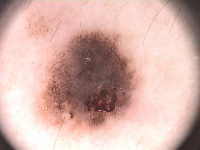</td><td>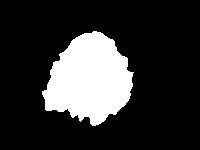</td></tr></table>



In [ ]:
!wget https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar


--2023-01-25 20:04:55--  https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/k88qukc20ljnbuo/PH2Dataset.rar [following]
--2023-01-25 20:04:56--  https://www.dropbox.com/s/raw/k88qukc20ljnbuo/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uca2d69d57627fc84ad21fbf047d.dl.dropboxusercontent.com/cd/0/inline/B1SRWyH5cmKYfNS50oqJjFjTWRUG4IxVWIic-3W_qTOQhV2pzwt9vWMXCUqJT01QsrfrvsX0W1IaWb4WY0-XisraubXviNhP3oLJFkXVuXYgkL25jIcWz4-xFc-OS7czZHRj0fZ5Id1zS0pHKdMx9UkGoCOmnBL64ab7Y2E0f9Rkyg/file# [following]
--2023-01-25 20:04:56--  https://uca2d69d57627fc84ad21fbf047d.dl.dropboxusercontent.com/cd/0/inline/B1SRWyH5cmKYfNS50oqJjFjTWRUG4IxVWIic-3W_qTOQhV2pzwt9vWMXCUqJT01QsrfrvsX0W

In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Изменим их размер на $256\times256 $ пикселей. 

In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
len(lesions)

200

Чтобы убедиться, что все корректно, нарисуем несколько изображений

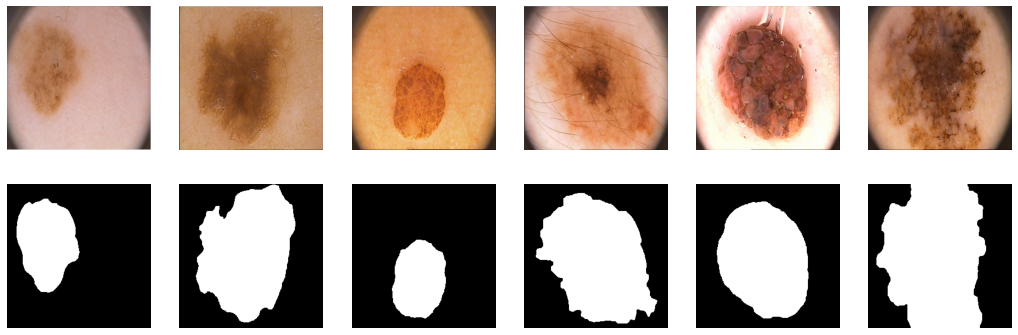

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i], cmap='gray')
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [ ]:
from torch.utils.data import DataLoader
batch_size = 5
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=False)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация архитектуры U-Net:
Самостоятельно напишем нейросетевую архитектуру для решения задачи семантической сегментации и попробуем испробовать различные лосс функции для неё.


## U-Net

**U-Net** — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации, но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

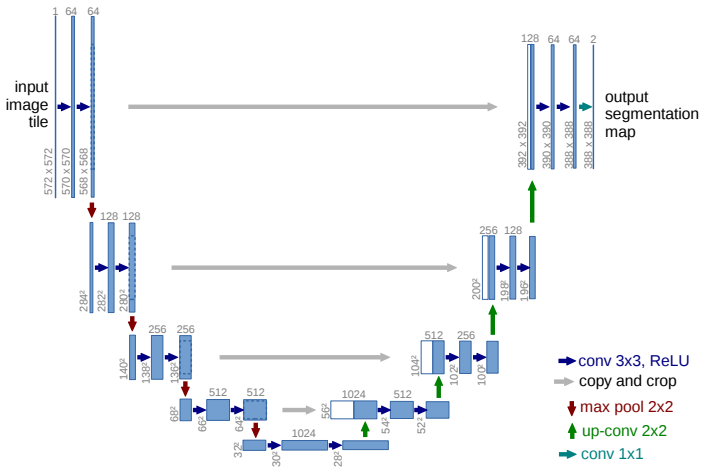

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
import time
from IPython.display import clear_output

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [ ]:
class DoubleConv(nn.Module):
  def __init__(self, in_ch, out_ch):
    super(DoubleConv, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),        
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),        
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace=True)
    )

  def forward(self, input_img):
    return self.conv(input_img)


class Encoder(nn.Module):
  def __init__(self, channels=(3,64,128,256,512,1024)):
    super(Encoder, self).__init__()

    self.enc = nn.ModuleList([DoubleConv(channels[i], channels[i+1]) for i in range(len(channels)-1)])
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

  def forward(self, input_img):
    skip_con = []
    for block in self.enc:
      input_img = block(input_img)
      skip_con.append(input_img)
      input_img = self.pool(input_img)
    return skip_con


class Decoder(nn.Module):
  def __init__(self, channels=(1024,512,256,128,64)):
    super(Decoder, self).__init__()
    
    self.channels = channels
    self.ups = nn.ModuleList([nn.ConvTranspose2d(channels[i], channels[i+1],kernel_size=2, stride=2) for i in range(len(channels)-1)])
    self.decs = nn.ModuleList([DoubleConv(channels[i], channels[i+1]) for i in range(len(channels)-1)]) 
    self.drop = nn.Dropout(0.5)

  def forward(self, input_img, skip_con):
    for i, s in zip(range(len(self.channels)-1), range(len(skip_con))):
      input_img = self.ups[i](input_img)
      input_img = torch.cat([input_img, skip_con[s]], dim=1)
      input_img = self.decs[i](input_img)
      input_img = self.drop(input_img)
    return input_img


class UNET(nn.Module):
  def __init__(self, enc_chs=(3,64,128,256,512,1024), dec_chs=(1024,512,256,128,64), num_class=1):
    super(UNET, self).__init__()
    self.encoder = Encoder(enc_chs)
    self.decoder = Decoder(dec_chs)
    self.final = nn.Conv2d(dec_chs[-1], num_class, kernel_size=1, padding=0)

  def forward(self, input_img):
    skip_con = self.encoder(input_img)
    out = self.decoder(skip_con[::-1][0], skip_con[::-1][1:])
    out = self.final(out)
        
    return out

## Метрика

Предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):

    outputs = outputs.squeeze(1).byte()  
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  

## Функция потерь BCE
Для начала воспользуемся *бинарной кросс-энтропией*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это логистическая функция.

Однако эта функция страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Выполним следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Новая функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [ ]:
def bce_loss(y_real, y_pred):
    return (torch.clamp(y_pred, 0) - y_real * y_pred + torch.log(1 + torch.exp(-abs(y_pred)))).mean()

## Тренировка



In [ ]:
def train(model, opt, loss_fn, metric, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))

    history = []

    for epoch in range(epochs):
        tic = time.time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_tr_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred) # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_tr_loss += loss.detach().cpu().numpy() / len(data_tr)

        metric_tr = score_model(model, metric, data_tr)

        avg_val_loss = 0
        model.eval()  # testing mode
        for X_batch, Y_batch in data_val:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            with torch.no_grad():
                Y_pred = model(X_batch)
                loss = loss_fn(Y_batch, Y_pred)
                avg_val_loss += loss.detach().cpu().numpy() / len(data_val)

        metric_val = score_model(model, metric, data_val)

        history.append((avg_tr_loss, metric_tr, avg_val_loss, metric_val))

        toc = time.time()
        print('loss: %f' % avg_tr_loss)

        # show intermediate results
        Y_hat = (model(X_val.to(device)) > 0.5).detach().cpu() # detach and put into cpu

        # Visualize tools
        clear_output(wait=True)
        for k in range(5):
            plt.subplot(2, 5, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Оригинал')
            plt.axis('off')

            plt.subplot(2, 5, k+6)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Маска')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_tr_loss))
        plt.show()
    
    return history

Функция для отрисовки графиков лосса и точности модели:

In [ ]:
def show_history(history):
    loss, acc, val_loss, val_acc = zip(*history)

    plt.figure(figsize=(16, 9))
    plt.plot(loss, label="train loss", color='darkviolet')
    plt.plot(val_loss, label="val loss", color='turquoise')
    plt.legend(loc='best')
    plt.xlabel("epochs", size = 16)
    plt.ylabel("loss", size = 16)
    plt.show()

    plt.figure(figsize=(16, 9))
    plt.plot(acc, label="train iou", color='darkviolet')
    plt.plot(val_acc, label="val iou", color='turquoise')
    plt.legend(loc='best')
    plt.xlabel("epochs", size = 16)
    plt.ylabel("IoU", size = 16)
    plt.show()

## Инференс

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [ ]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = model(data.to(device)).cpu() > 0.5
    return np.array(Y_pred)

In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    with torch.no_grad():
        for X_batch, Y_label in data:
            Y_pred = (model(X_batch.to(device)) > 0.5)
            scores += metric(Y_pred, Y_label.to(device)).mean().item()

    return scores/len(data)

## **Обучение модели**


In [ ]:
unet_bce = UNET().to(device)

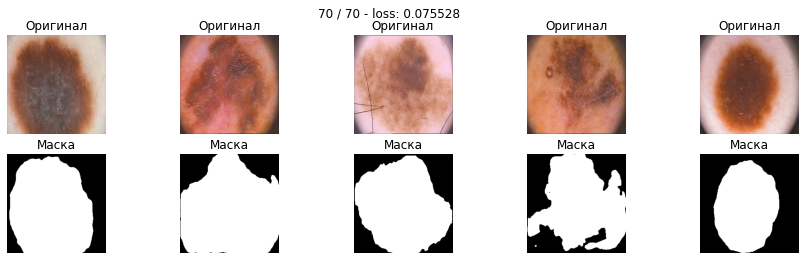

In [ ]:
bce_history = train(unet_bce, optim.Adam(unet_bce.parameters(), lr=1e-4), bce_loss, iou_pytorch, 70, data_tr, data_val)

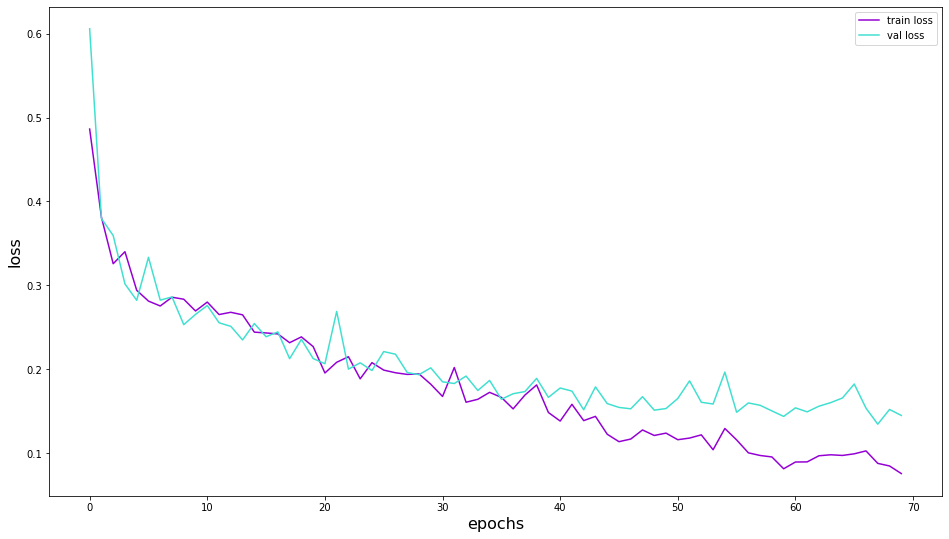

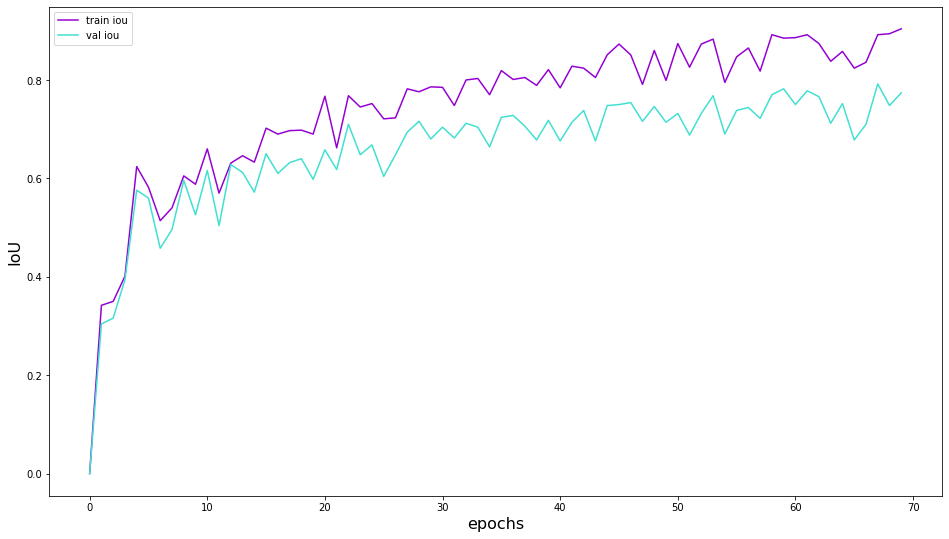

In [ ]:
show_history(bce_history)

Проверка на тестовых данных

In [ ]:
score_model(unet_bce, iou_pytorch, data_ts)

0.820000046491623

-----------------------------------------------------------------------------------------

## **Дополнительные функции потерь**

Попробуем обучить модель с использованием других лоссов.

### *1. Dice coefficient:*
Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но для градиентного спуска дифференцируемость необходима. В данном случае мы можем выполнить следующее приближение:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$


In [ ]:
def dice_loss(y_real, y_pred):
    y_pred = torch.sigmoid(y_pred)
    smooth = 1e-8
    num = (y_real * y_pred).sum()
    den = (y_real + y_pred).sum()
    dice = (2 * num + smooth) / (den + smooth)
    return 1 - dice

In [ ]:
unet_dice = UNET().to(device)

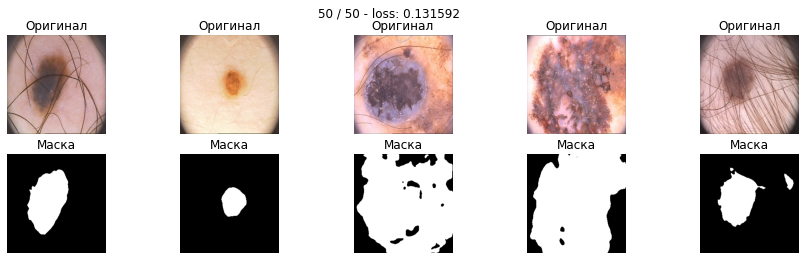

In [ ]:
dice_history = train(unet_dice, optim.Adam(unet_dice.parameters(), lr=1e-4), dice_loss, iou_pytorch, 50, data_tr, data_val)

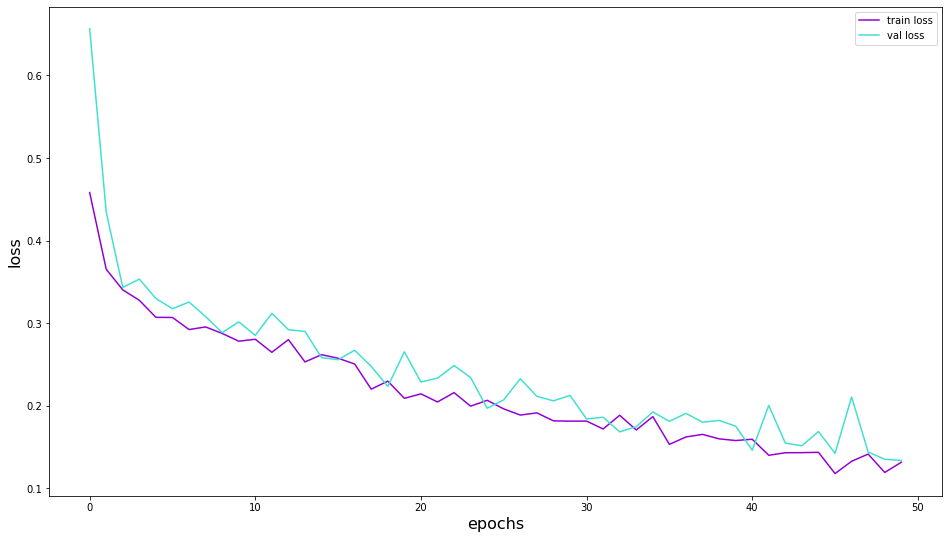

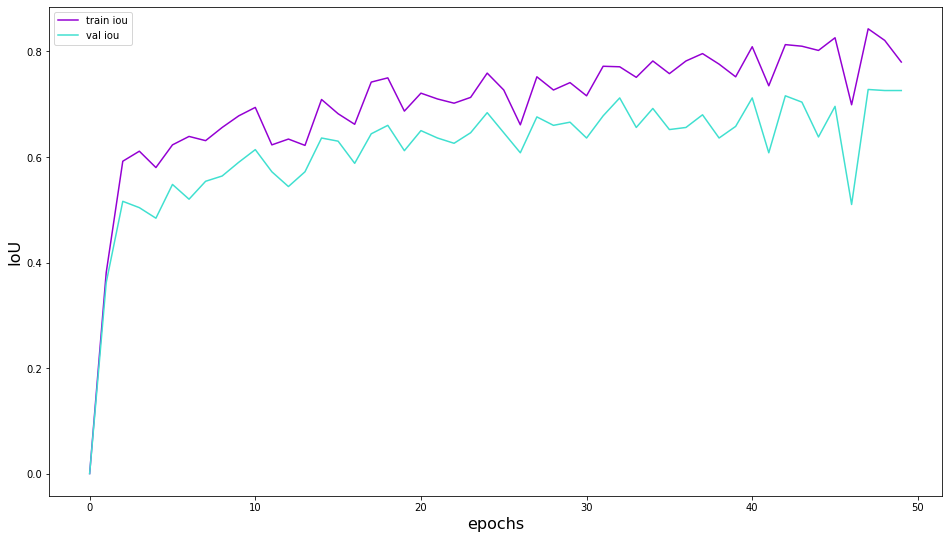

In [ ]:
show_history(dice_history)

In [ ]:
score_model(unet_dice, iou_pytorch, data_ts)

0.7180000305175781

### *2. Focal loss:*

Вспомним BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой функцией заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** (переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [ ]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    y_pred = torch.clamp(torch.sigmoid(y_pred), eps, 1-eps)
    return -((1 - y_pred)**gamma * y_real * torch.log(y_pred) + (1 - y_real) * torch.log(1 - y_pred)).mean()

In [ ]:
unet_focal = UNET().to(device)

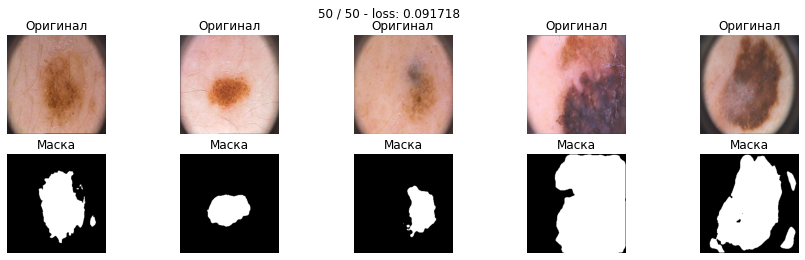

In [ ]:
focal_history = train(unet_focal, optim.Adam(unet_focal.parameters(), lr=1e-4), focal_loss, iou_pytorch, 50, data_tr, data_val)

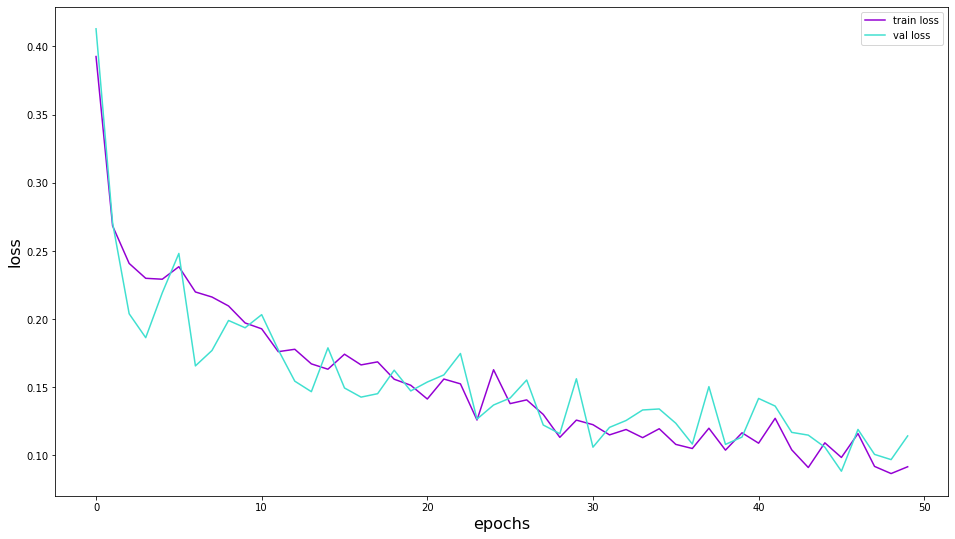

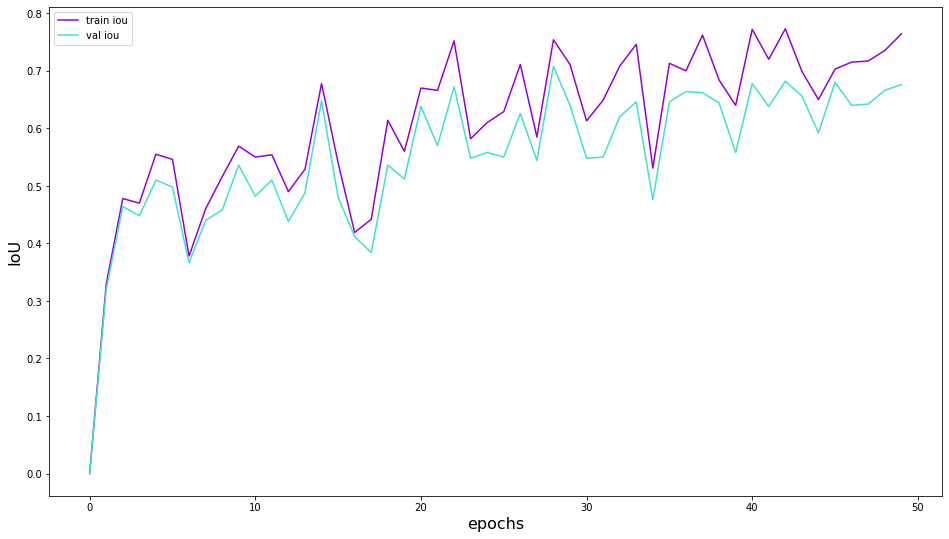

In [ ]:
show_history(focal_history)

In [ ]:
score_model(unet_focal, iou_pytorch, data_ts)

0.7320000529289246

# Итоги


Была поставлена задача сегментации родинок и меланом с картинок. Для решения задачи использовалась архитектура U-Net

Метрика и лосс

Для оценки качества работы моделей использовалась метрика IoU - Intersection over Union.

В работе использовались следующие лосс-функции:
* BCE loss
* Dice loss
* Focal loss

### Наглядное сравнение результатов

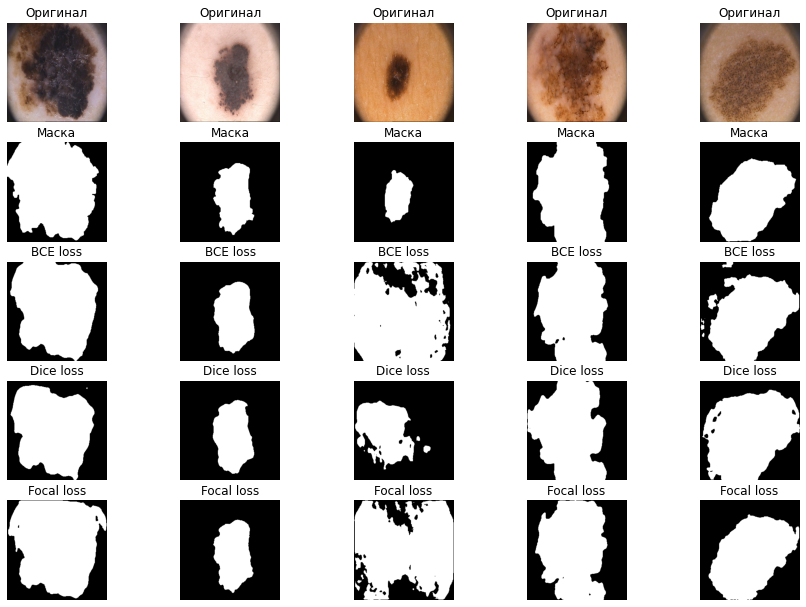

In [ ]:
X_ts, Y_ts = next(iter(data_ts))

plt.figure(figsize=(15, 15))
for k in range(5):
    plt.subplot(7, 5, k+1)
    plt.imshow(np.rollaxis(X_ts[k].numpy(), 0, 3), cmap='gray')
    plt.title('Оригинал')
    plt.axis('off')

    plt.subplot(7, 5, k+6)
    plt.imshow((np.rollaxis(Y_ts[k].numpy(), 0, 3).reshape(256,256)), cmap='gray')
    plt.title('Маска')
    plt.axis('off')

    plt.subplot(7, 5, k+11)
    plt.imshow(predict(unet_bce, X_ts)[k, 0], cmap='gray')
    plt.title('BCE loss')
    plt.axis('off')

    plt.subplot(7, 5, k+16)
    plt.imshow(predict(unet_dice, X_ts)[k, 0], cmap='gray')
    plt.title('Dice loss')
    plt.axis('off')

    plt.subplot(7, 5, k+21)
    plt.imshow(predict(unet_focal, X_ts)[k, 0], cmap='gray')
    plt.title('Focal loss')
    plt.axis('off')

### Оценка качества моделей

Рассмотрим графики изменения лосс-функций на валидационной выборке для каждой модели. Обе модели обучались на 30 эпохах с одинаковым оптимизатором.

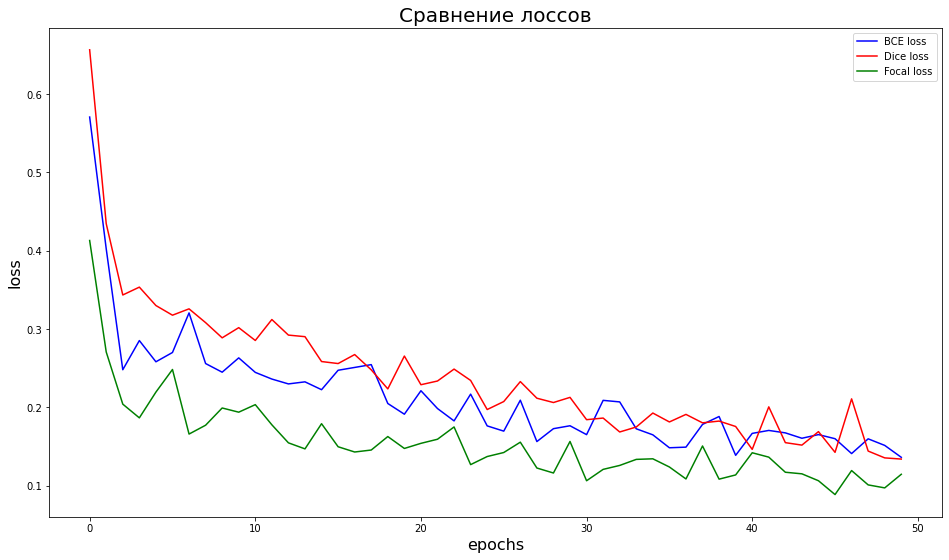

In [ ]:
_, _, bce_unet_loss, _ = zip(*bce_history)
_, _, dice_unet_loss, _ = zip(*dice_history)
_, _, focal_unet_loss, _ = zip(*focal_history)

plt.figure(figsize=(16, 9))


plt.plot(bce_unet_loss, label="BCE loss", color='b')
plt.plot(dice_unet_loss, label="Dice loss", color='r')
plt.plot(focal_unet_loss, label="Focal loss", color='g')
plt.legend(loc='best')
plt.xlabel("epochs", size=16)
plt.ylabel("loss", size=16)
plt.title("Сравнение лоссов", size=20)

plt.show()

По графику видно, что лоссы сходятся примерно к одному и тому же значению. 

Отметим, что при использовании BCE лосса появляется больше скачков на графике.

Можно заметить, что график focal лосса в основном располагается ниже двух других, то есть он немного выигрывает у остальных лоссов.


Построим аналогичный график изменения значения метрики IoU.

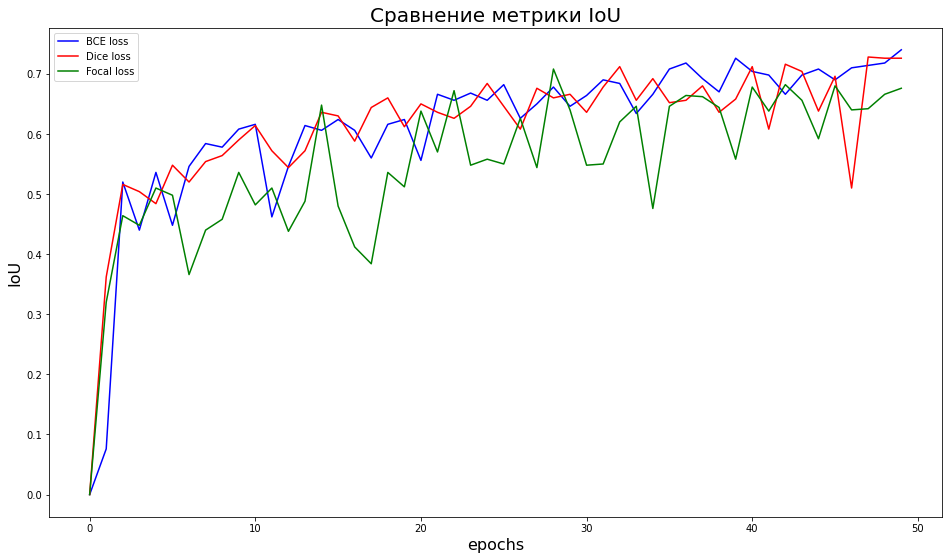

In [ ]:
_, _, _, bce_unet_iou = zip(*bce_history)
_, _, _, dice_unet_iou = zip(*dice_history)
_, _, _, focal_unet_iou = zip(*focal_history)

plt.figure(figsize=(16, 9))


plt.plot(bce_unet_iou, label='BCE loss', color='b')
plt.plot(dice_unet_iou, label='Dice loss', color='r')
plt.plot(focal_unet_iou, label='Focal loss', color='g')
plt.legend(loc='best')
plt.xlabel('epochs', size=16)
plt.ylabel('IoU', size=16)
plt.title('Сравнение метрики IoU', size=20)

plt.show()

Метрика при использовании BCE и Dice выше, чем при использовании Focal loss. Но нужно учитывать, что у фокала есть гиперпараметр $\gamma$, регулируя который можно изменить поведение модели.



In [ ]:
import pandas as pd

df = pd.DataFrame(columns=['UNet'], index=['BCE loss', 'Dice loss', 'Focal loss'])

df['UNet']['BCE loss'] = score_model(unet_bce, iou_pytorch, data_ts)
df['UNet']['Dice loss'] = score_model(unet_dice, iou_pytorch, data_ts)
df['UNet']['Focal loss'] = score_model(unet_focal, iou_pytorch, data_ts)
df

,UNet
BCE loss,0.754
Dice loss,0.718
Focal loss,0.732


## Варианты улучшения качества модели

В ходе работы над проектом мы пришли к выводу, что для усовершенствования модели нужно сделать следующее (в идеале - на более мощных вычислительных мощностях):


*   Поэкспериментировать с количеством каналов, конволюционных блоков
*   Поэкспериментировать с параметрами 
*   Поэкспериментировать с батчами и эпохами
*   Добавить аугментацию
*   Запомнить веса модели на эпохе с наименьшим лоссом
*   Попробовать использовать входное изображение большего разрешения 




